In [2]:
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cvxopt
from cvxopt import matrix
import time
from datetime import datetime

In [86]:
all = 11 # 11 代表十一支產業代表指數
num = all - 1 # 11 - 1 其他代表十支產業代表指數
# define function
def price(all_fund_price, all_index_price, number): # number代表第幾支基金
    other = list(range(all)) 
    fund_price = np.zeros((len(all_fund_price), 1))
    for i in range (len(all_fund_price)):
        fund_price[i] = all_fund_price.iloc[i, number]
    index_price = np.zeros((len(all_fund_price) , num))
    if number-1 in other: other.remove(number-1) # 把我們想要組合出的基金刪掉
    for i in range (len(all_fund_price)):
        for k,j in enumerate(other):
            index_price[i , k] = all_index_price.iloc[i , j]
    for i in range (len(fund_price)):
        if (i != len(fund_price) - 1):
            # 以log計算return => 跌加起來就可以計算一段時間的報酬
            fund_price[i] = math.log((fund_price[i + 1] / fund_price[i]) , 10) 
    for i in range (len(index_price)):
        for j in range (index_price.shape[1]):
            if (i != len(index_price) - 1):
                index_price[i , j] = math.log((index_price[i + 1 , j] / index_price[i , j]) , 10)
    
    fund_price = np.delete(fund_price, [(len(all_fund_price)-1)], axis = 0)
    index_price = np.delete(index_price, [(len(all_fund_price)-1)], axis = 0)
    return fund_price, index_price

def ls(fund_price, index_price):
    #Use Least Squares Method without any constraint.
    indexT = index_price.T #index return的轉置矩陣
    weight = np.dot(np.dot(np.linalg.inv(np.dot(indexT , index_price)), indexT), fund_price)
    return weight

def qp1(fund_price, index_price):
    #Use Quadratic Programming Method without any constraint.
    #裡面的 cvxopt.solvers.qp(P,q,G,h,A,b) 二次規劃求解是欲解出[(1/2)* x * P * x'+ q' * x]的最小值
    indexT = index_price.T #index return的轉置矩陣
    P = np.asmatrix(np.dot(indexT , index_price))
    # 代表 Pi 總和，代表index 跟 indexT的內積
    q = np.asmatrix(np.dot(indexT , fund_price))
    # 代表 qi 總和 ，代表fund 跟 indexT的內積
    P = matrix(P*2) #10*1 matrix p
    q = matrix(q*(-2)) #10*1 vector q
    G = matrix(np.asmatrix((-1)*np.zeros([num,num])))
    h = matrix(np.asmatrix(np.zeros([num,1])))
    #程式裡的限制式為G*x <= h,x為權重 Ｇ為0 h為0 代表權重可為任何數(無限制)
    A = matrix(np.asmatrix(np.zeros([1,num])))
    b = matrix([0.])
    #程式裡的限制式為A*x = b,x為權重 A為值均為0的1*10矩陣 b為0 代表權重和可為任何數(無限制)
    # weight = cvxopt.solvers.qp(P,q,G,h,A,b)
    weight = cvxopt.solvers.qp(P,q,G,h)
    return weight['x']

def qp2(fund_price, index_price):
    #Use Quadratic Programming Method and let the sum of weight equals 1.
    #裡面的 cvxopt.solvers.qp(P,q,G,h,A,b) 二次規劃求解是欲解出[(1/2)* x * P * x'+ q' * x]的最小值
    indexT = index_price.T #index return的轉置矩陣
    P = np.asmatrix(np.dot(indexT , index_price))
    # 代表 Pi 總和，代表index 跟 indexT的內積
    q = np.asmatrix(np.dot(indexT , fund_price))
    # 代表 qi 總和 ，代表fund 跟 indexT的內積
    P = matrix(P*2) #10*10 matrix p
    q = matrix(q*(-2)) #10*1 vector q
    G = matrix(np.asmatrix((-1)*np.zeros([num,num])))
    h = matrix(np.asmatrix(np.zeros([num,1])))
    #程式裡的限制式為G*x <= h,x為權重 Ｇ為0 h為0 代表權重可為任何數(無限制)
    A = matrix(np.asmatrix(np.ones([1,num])))
    b = matrix([1.])
    #程式裡的限制式為A*x = b,x為權重 A為值均為1的1*10矩陣 b為1 代表權重和為一
    weight = cvxopt.solvers.qp(P,q,G,h,A,b)
    return weight['x']

def qp3(fund_price, index_price):
    #Use Quadratic Programming Method and let the sum of weight is equal to 1 
    #and the weight of all constituent stocks are greater or equal to 0.
    #裡面的 cvxopt.solvers.qp(P,q,G,h,A,b) 二次規劃求解是欲解出[(1/2)* x * P * x'+ q' * x]的最小值
    indexT = index_price.T #index return的轉置矩陣
    P = np.asmatrix(np.dot(indexT , index_price))
    # 代表 Pi 總和，代表index 跟 indexT的內積
    q = np.asmatrix(np.dot(indexT , fund_price))
    # 代表 qi 總和 ，代表fund 跟 indexT的內積
    P = matrix(P*2) #10*10 matrix p
    q = matrix(q*(-2)) #10*1 vector q
    G = matrix(np.asmatrix((-1)*np.eye(num)))
    h = matrix(np.asmatrix(np.zeros([num,1])))
    #程式裡的限制式為G*x <= h,x為權重 Ｇ為-1 h為0 代表權重非負
    A = matrix(np.asmatrix(np.ones([1,num])))
    b = matrix([1.])
    #程式裡的限制式為A*x = b,x為權重 A為值均為1的1*10矩陣 b為1 代表權重和為一
    weight = cvxopt.solvers.qp(P,q,G,h,A,b)
    return weight['x']
    
def tracking_price(index_return, fund_price, weight, number):
    tracking_return = np.dot(index_return , weight)
    fund_tracking = np.zeros((len(fund_price) , 1))
    fund_tracking[0] = fund_price.iloc[0, number]
    for i in range(len(tracking_return)):
        return_rate = 10 ** tracking_return[i] #預估的基金報酬率
        fund_tracking[i + 1] = fund_tracking[i] * return_rate
    return fund_tracking, tracking_return

def R_Square(predict, gt):
    gt_mean = np.mean(gt)
    sse = 0
    sst = 0
    for i in range(len(predict)):
        sse += (predict[i] - gt[i])**2
        sst += (gt[i] - gt_mean)**2
    return (1-sse/sst)

def Error(predict, gt):
    return_predict = np.zeros(len(predict)-1)
    return_gt = np.zeros(len(predict)-1)
    for i in range(len(predict)-1):
        return_predict[i] = math.log((predict[i+1]/predict[i]))
        return_gt[i] = math.log((gt[i+1]/gt[i]))
    difference = return_gt - return_predict
    return np.mean(difference), np.std(difference), np.linalg.norm(difference), np.mean(abs(difference)), np.mean(difference**2)

In [18]:
# 讀資料
all_fund_price = pd.read_excel("完成版.xlsx")
all_index_price = all_fund_price[['SPXESFUT' , 'SPXESUP' , 'SPXETCT (Heavy)' , 'SPXETCT (Light)' , 'SPXETCT (Moderate)' , 'SPXETCT' , 'SPXELSUP' , 'SPRESUP' , 'SPMESUP' , 'SPSESUP' , 'S&P United States LargeMidCap ESG Index']]


In [94]:
# 基金價格追蹤
number = 2
# 用log取得fund和index的return
fund_return, index_return = price(all_fund_price, all_index_price, number)
#weight = ls(fund_return, index_return)
#weight = qp1(fund_return, index_return)
#weight = qp2(fund_return, index_return)
weight = qp3(fund_return, index_return)
fund_tracking, tracking_return = tracking_price(index_return, all_fund_price, weight, number)

     pcost       dcost       gap    pres   dres
 0: -4.2361e-02 -1.0445e+00  1e+00  1e-16  3e+00
 1: -4.2378e-02 -5.4491e-02  1e-02  6e-17  4e-02
 2: -4.2899e-02 -4.4054e-02  1e-03  7e-17  4e-03
 3: -4.3321e-02 -4.3690e-02  4e-04  3e-17  4e-17
 4: -4.3382e-02 -4.3436e-02  5e-05  8e-17  5e-17
 5: -4.3402e-02 -4.3413e-02  1e-05  1e-16  4e-17
 6: -4.3405e-02 -4.3406e-02  1e-06  2e-16  2e-17
 7: -4.3405e-02 -4.3405e-02  2e-07  1e-16  1e-17
 8: -4.3405e-02 -4.3405e-02  5e-08  1e-16  3e-17
Optimal solution found.


In [95]:
print(f'Weight:\n{weight}')
print(f'Sum:{sum(weight)}')

Weight:
[ 7.69e-01]
[ 1.83e-03]
[ 3.77e-02]
[ 1.62e-02]
[ 4.61e-03]
[ 3.08e-04]
[ 1.02e-03]
[ 9.25e-05]
[ 9.27e-05]
[ 1.69e-01]

Sum:1.0


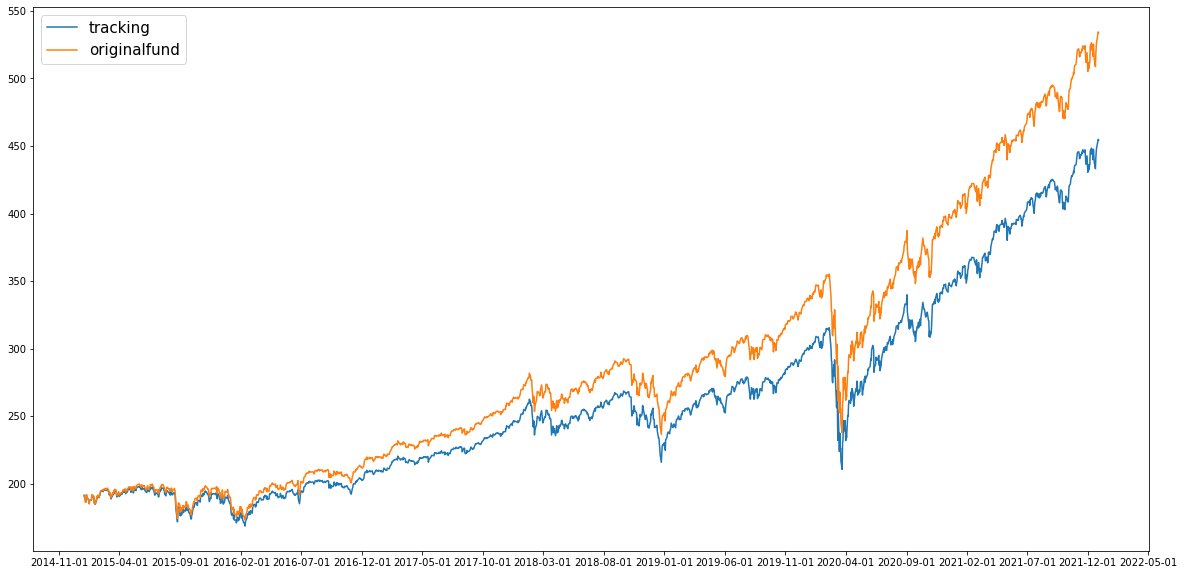

In [96]:
# 價格追蹤結果圖
date = all_fund_price['Date']
date = pd.to_datetime(date) # 轉為轉為datetime的時間資料型態，轉換後可以對時間資料做計算，ex.計算時間差
plt.figure(figsize=(20,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.plot(date , fund_tracking)
plt.plot(date , all_fund_price.iloc[:, number])#[:,i]
plt.legend(['tracking', 'originalfund'] , fontsize = 15)

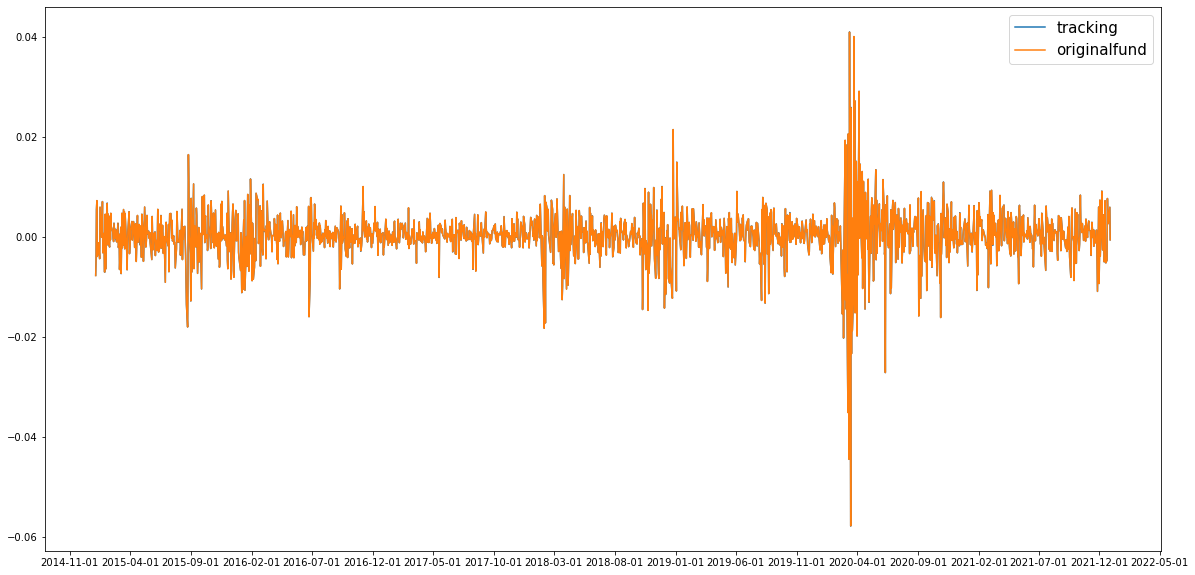

In [63]:
# 報酬追蹤結果圖
date = all_fund_price['Date']
date = pd.to_datetime(date)
date = date.iloc[1:]
plt.figure(figsize=(20,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.plot(date , tracking_return)
plt.plot(date , fund_return)
plt.legend(['tracking', 'originalfund'] , fontsize = 15)

In [97]:
# 各誤差值計算
r_square_error = R_Square(fund_tracking, all_fund_price.iloc[:, number])
print("R_Square :", r_square_error)

td, te, norm_2, MAE, MSE = Error(fund_tracking, all_fund_price.iloc[:, number])
print("Tracking Difference :", td)
print("Tracking Error :", te)
print("2-Norm Error :", norm_2)
print("MAE :", MAE)
print("MSE :", MSE)

R_Square : [0.86919082]
Tracking Difference : 9.165111721319258e-05
Tracking Error : 0.00010270802411306242
2-Norm Error : 0.005773305328916472
MAE : 0.00010993186070364607
MSE : 1.894886550363578e-08


In [102]:
sum(fund_return)

array([0.44553212])